In [1]:
import numpy as np
import pandas as pd
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
df = pd.read_csv("../modified_data/pol_svi_sc_merged.csv")
df.head()

,FIPS,3/31/21,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,...,Hopefulness,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct
0,1001,6589,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,...,91.163142,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365
1,1003,20505,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,...,82.484017,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030
2,1005,2227,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,...,61.927181,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173
3,1007,2542,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,...,85.258871,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280
4,1009,6444,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,...,79.492703,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378


In [3]:
#set index to FIPS
df = df.set_index(df['FIPS'])
df= df.drop('FIPS', axis=1)

In [4]:
#rename target column
df = df.rename(columns={'3/31/21':'first_year_cases'})

In [5]:
#create variable for case% for each counties population
df['case_pct'] = df['first_year_cases']/df['E_TOTPOP']*100
df['case_pct'].head()

FIPS
1001    11.936594
1003     9.853104
1005     8.637809
1007    11.284237
1009    11.178767
Name: case_pct, dtype: float64

In [6]:
df['case_pct'].describe()

count    3058.000000
mean        9.426600
std         3.045809
min         0.000000
25%         7.713422
50%         9.466675
75%        11.176131
max        38.010657
Name: case_pct, dtype: float64

In [7]:
# bin and cut the case_pct column into 2 classifications
# q = df['case_pct'].quantile(.75)
q = df['case_pct'].quantile(.9)
bins = [0, q , 40]
labels = ['low','high']
df['case_class'] = pd.cut(df['case_pct'], bins, labels = labels)
df['case_class']

FIPS
1001      low
1003      low
1005      low
1007      low
1009      low
         ... 
56037     low
56039    high
56041     low
56043     low
56045     low
Name: case_class, Length: 3058, dtype: category
Categories (2, object): ['low' < 'high']

In [8]:
df['case_class'].value_counts()

low     2728
high     306
Name: case_class, dtype: int64

In [9]:
#drop unneeded columns
df = df.drop('case_pct', axis =1)
df

,first_year_cases,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,...,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,case_class
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,6589,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,8050.0,...,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,low
1003,20505,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,40665.0,...,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030,low
1005,2227,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,4634.0,...,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173,low
1007,2542,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,3661.0,...,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280,low
1009,6444,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,10233.0,...,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,4022,10426.975725,44117.0,19628.0,15871.0,5237.0,1213.0,32624.0,2549.0,4721.0,...,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,22.894957,low
56039,3609,3996.844622,23059.0,13680.0,9158.0,1619.0,210.0,53703.0,958.0,3135.0,...,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,66.599040,high
56041,2128,2081.719807,20609.0,8972.0,7735.0,2552.0,614.0,27009.0,934.0,2498.0,...,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,16.819960,low


In [10]:
# #drop unneeded columns first_year_cases
# df = df.drop('first_year_cases', axis =1)
# df

In [11]:
#turn case % classifications into binary 
df = pd.get_dummies(df, columns = ['case_class'])
df

,first_year_cases,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,...,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,case_class_low,case_class_high
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,6589,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,8050.0,...,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,1,0
1003,20505,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,40665.0,...,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030,1,0
1005,2227,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,4634.0,...,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173,1,0
1007,2542,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,3661.0,...,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280,1,0
1009,6444,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,10233.0,...,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,4022,10426.975725,44117.0,19628.0,15871.0,5237.0,1213.0,32624.0,2549.0,4721.0,...,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,22.894957,1,0
56039,3609,3996.844622,23059.0,13680.0,9158.0,1619.0,210.0,53703.0,958.0,3135.0,...,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,66.599040,0,1
56041,2128,2081.719807,20609.0,8972.0,7735.0,2552.0,614.0,27009.0,934.0,2498.0,...,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,16.819960,1,0


## RF Regressor

In [12]:
df.shape

(3058, 105)

In [13]:
# Define feature set (x)
X = df.drop(['case_class_low','case_class_high'], axis=1).values

#Define (y)
y= df['case_class_high'].values

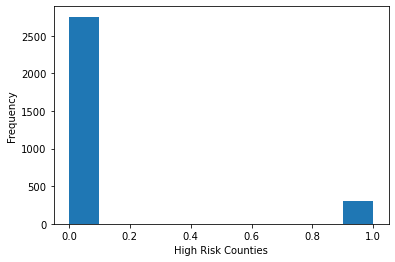

In [14]:
# frequency histogram to see how many counties are high risk and low risk
plt.hist(df["case_class_high"])
plt.xlabel("High Risk Counties")
plt.ylabel("Frequency")
plt.show()

In [15]:
#split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 ,random_state= 42) 

In [16]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2140, 103)
(918, 103)
(2140,)
(918,)


In [17]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators = 175, random_state = 42)

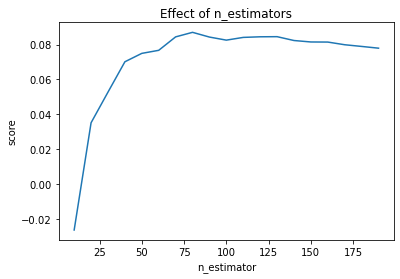

In [19]:
# Try different numbers of n_estimators 
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_model.set_params(n_estimators=n)
    rf_model.fit(X_train, y_train)
    scores.append(rf_model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [20]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [21]:
# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)

In [22]:
y_pred


array([0.00526316, 0.05263158, 0.01052632, 0.24210526, 0.17894737,
       0.44736842, 0.12631579, 0.01052632, 0.41052632, 0.34210526,
       0.01578947, 0.        , 0.02105263, 0.33684211, 0.13684211,
       0.03157895, 0.        , 0.42105263, 0.01052632, 0.15263158,
       0.18947368, 0.00526316, 0.12105263, 0.45789474, 0.43684211,
       0.02631579, 0.04736842, 0.1       , 0.11052632, 0.00526316,
       0.36315789, 0.31578947, 0.05263158, 0.19473684, 0.09473684,
       0.01578947, 0.11578947, 0.05789474, 0.03157895, 0.06842105,
       0.07894737, 0.        , 0.10526316, 0.03684211, 0.06315789,
       0.03684211, 0.        , 0.09473684, 0.06842105, 0.00526316,
       0.52631579, 0.03157895, 0.01052632, 0.26842105, 0.08947368,
       0.12105263, 0.25789474, 0.13157895, 0.00526316, 0.32105263,
       0.00526316, 0.16315789, 0.04736842, 0.61052632, 0.        ,
       0.01578947, 0.01052632, 0.04736842, 0.08947368, 0.10526316,
       0.11052632, 0.        , 0.05263158, 0.13157895, 0.04210

In [23]:
#mean squared error (MSE)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE)

MSE: 0.0856121642254932


In [24]:
# root mean squared error (RMSE)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:",RMSE )

RMSE: 0.29259556426147887


In [25]:
# mean absolute error (MAE)
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.1765508542598326


In [26]:
# mean absolute percentage error 
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MAPE: 442097424721004.75


In [27]:
#accuracy 
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -442097424720904.75 %.


In [28]:
importances = rf_model.feature_importances_
importances

array([3.71145777e-02, 1.69236367e-02, 9.13763237e-03, 4.65656017e-03,
       4.70804374e-03, 4.53944533e-03, 5.58234212e-03, 6.50551972e-03,
       3.91311649e-03, 5.39872312e-03, 4.15466948e-03, 4.85452065e-03,
       4.97634367e-03, 5.99514569e-03, 7.82399904e-03, 5.50351733e-03,
       1.62452407e-02, 4.97097802e-03, 4.64803936e-03, 1.05739121e-02,
       4.96243546e-03, 9.07087667e-03, 7.07333442e-03, 1.15723701e-02,
       5.50492641e-03, 9.56673035e-03, 5.76077926e-03, 9.77452027e-03,
       9.37186344e-03, 1.12499888e-02, 8.27864183e-03, 1.27343236e-02,
       1.49890087e-02, 6.12380357e-03, 2.43611142e-02, 5.95452144e-03,
       9.74045155e-03, 6.93173680e-03, 1.25087632e-02, 8.13455389e-03,
       6.69263315e-03, 6.67601813e-03, 8.48850061e-03, 6.47519020e-03,
       1.10412643e-02, 1.14994806e-02, 1.10066439e-02, 9.24514008e-03,
       9.36698287e-03, 8.55837449e-03, 9.22479100e-03, 7.86474344e-03,
       1.27745535e-02, 1.35205263e-02, 6.18553286e-03, 2.20178610e-02,
      

In [29]:
X = df.drop(['case_class_low','case_class_high'], axis=1).columns
sorted(zip(rf_model.feature_importances_, X), reverse=True)

[(0.047767792630069576, 'Employment Rate'),
 (0.037114577686126124, 'first_year_cases'),
 (0.028682846618000087, 'Openness'),
 (0.0256908689339494, 'Conscientiousness'),
 (0.024361114203024323, 'EP_GROUPQ'),
 (0.023811955816464385, 'Empathy'),
 (0.023753160771761907, 'dem_pct'),
 (0.022498712023639584, 'Collectivism'),
 (0.022017861030845985, 'EPL_GROUPQ'),
 (0.021161548166200743, 'Hopefulness'),
 (0.02101708056972357, 'Work Ethic'),
 (0.01904940068887072, 'EP_UNINSUR'),
 (0.01846885644298339, 'Neuroticism'),
 (0.018276152770752414, 'Risk Taking'),
 (0.0181551289021939, 'Entrepreneurship'),
 (0.0177005829358211, 'Selflessness'),
 (0.017467983136742138, 'Religiosity'),
 (0.017225220126546977, 'Gender Equality'),
 (0.01713890236237318, 'Tolerance'),
 (0.016923636664605626, 'AREA_SQMI'),
 (0.01624524066597041, 'E_MOBILE'),
 (0.014989008698284487, 'EP_CROWD'),
 (0.014639184828984811, 'Agreeableness'),
 (0.01385268428648426, 'Conflict Awareness'),
 (0.013520526281821226, 'EPL_CROWD'),
 (0.0